# Aggregated model - phylum - test set: 3 domain features
# Table of contents 
1. [Linear Regression](#LinearRegression)
2. [MLP (Dense)](#MLP)
3. [AE combined latent](#AE_combined)
4. [AE OTU latent](#AE_latentOTU)

In [1]:
from data import *
from train_2 import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures( \
        metadata_names=['age','Temperature','Precipitation3Days'],
        otu_filename='data/Aggregated/otu_table_Phylum.csv',
        metadata_filename='data/Aggregated/metadata_table_all_80.csv')

In [3]:
print(df_microbioma_train.shape[1])
print(df_microbioma_test.shape)

16
(373, 16)


In [4]:
print('TRAIN:')
print('age:' + str(df_domain_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_test.loc[:,'Temperature'].mean()))

TRAIN:
age:9.131498470948012
rain:0.4424182545283462
Tª:69.01096212655845
TEST:
age:9.091152815013405
rain:0.4129758713136729
Tª:69.06434316353888


### Get numpy objects

In [5]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

### Compute default error

In [6]:
# Absolute abundance transformed to TSS (with epsilon=1E-6)
def transform_to_rel_abundance(dataset):
    epsilon=1E-6
    sum_per_sample = dataset.sum(axis=1)
    num_samples = sum_per_sample.shape
    num_OTUs = np.shape(dataset)[-1] 
    sum_per_sample = sum_per_sample + (num_OTUs * epsilon)
    dividend=dataset+epsilon
    dataset_rel_abund = np.divide(dividend,sum_per_sample[:,None])
    #display(Markdown("{}</p>".format(np.array2string(actual_array,precision=6,floatmode='fixed'))))
    #actual_array.sum(axis=1)
    return dataset_rel_abund

#### Pearson correlation

In [7]:
data_microbioma_rel = transform_to_rel_abundance(data_microbioma_train)

random_seed=347
folds=5
tf.random.set_seed(random_seed) # BGJ
kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
tf.random.set_seed(random_seed)
tot_cv_r = 0.0
for train_index, test_index in kf.split(data_microbioma_rel):
    m_train, m_test = data_microbioma_rel[train_index], data_microbioma_rel[test_index]
    # prediction = average training samples
    pred = data_microbioma_rel[train_index].mean(axis=0)
    tot = 0.0
    count = 0
    for i,actual in enumerate(data_microbioma_rel[test_index]):
        r, _ = scipy.stats.pearsonr(actual,pred)
        #r = pearson_correlation_OTU_vector(actual,pred)
        if not np.isnan(r):
            count += 1
            tot += r
    r_cv = tot/count
    #print(r_cv)
    tot_cv_r += r_cv
tot_cv_r/folds     
        
    

0.9368167961690712

#### Bray-Curtis

In [8]:
from skbio.diversity import beta_diversity

data_microbioma_rel = transform_to_rel_abundance(data_microbioma_train)

random_seed=347
folds=5
tf.random.set_seed(random_seed) # BGJ
kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
tf.random.set_seed(random_seed)
tot_cv = 0.0
for train_index, test_index in kf.split(data_microbioma_rel):
    m_train, m_test = data_microbioma_rel[train_index], data_microbioma_rel[test_index]
    # prediction = average training samples
    pred = data_microbioma_rel[train_index].mean(axis=0)
    tot_bc = 0.0
    for i,actual in enumerate(data_microbioma_rel[test_index]):
        bc_dm = beta_diversity("braycurtis", [actual,pred]) # Source: http://scikit-bio.org/docs/0.4.2/diversity.html
        bc = bc_dm[0,1]
        tot_bc += bc
    bc_cv = tot_bc/(test_index.shape[0])
    #print(bc_cv)
    tot_cv += bc_cv
tot_cv/folds

0.22694927885119304

# 1. Linear regression <a name="LinearRegression"></a>

In [9]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [10]:
def model_fn():
    m = model(shape_in=data_domain_train.shape[1],
              shape_out=data_microbioma_train.shape[1],
              output_transform=None)
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [11]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>98</b></p>

<b>loss</b>: 1.9893 (min: 1.9629, max: 2.0159)

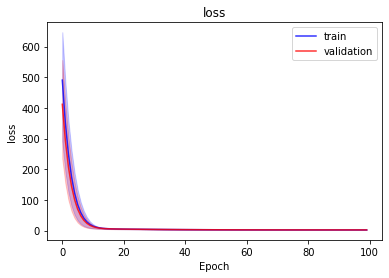

<b>domain_BrayCurtis</b>: 0.2000 (min: 0.1991, max: 0.2019)

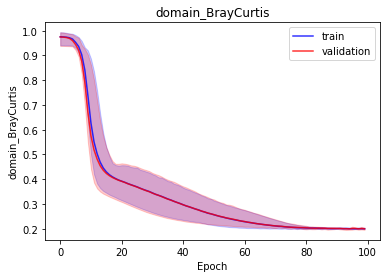

<b>domain_pearson_corr</b>: 0.9324 (min: 0.9305, max: 0.9334)

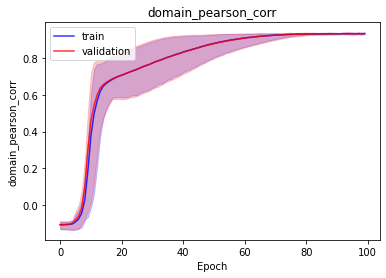

<b>domain_jensen_shannon_divergence</b>: 0.2055 (min: 0.1994, max: 0.2110)

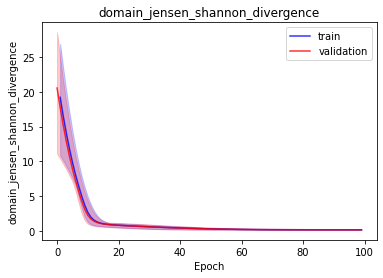

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 1.9892640216465232 | 1.9628608558010403 | 2.015923051264874 |
| domain_BrayCurtis | 0.19998088479042053 | 0.1990559846162796 | 0.2019050121307373 |
| domain_pearson_corr | 0.9324414134025574 | 0.9304880499839783 | 0.9333767890930176 |
| domain_jensen_shannon_divergence | 0.20548777282238007 | 0.19941124320030212 | 0.2110282927751541 |


[('best_lost_epoch', 98),
 ('val_loss', [1.9955046568598065, 1.9113400833947318, 2.1199123518807546]),
 ('val_domain_BrayCurtis', [0.20069921, 0.19653785, 0.20726769]),
 ('val_domain_pearson_corr', [0.9321882, 0.9254775, 0.93748164]),
 ('val_domain_jensen_shannon_divergence',
  [0.20677976, 0.18663779, 0.23915187])]

In [12]:
print_results(results)

In [13]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_linear_regresion_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.20403046905994415 | 0.20155400037765503 | 0.20705044269561768 |
| pearson_corr | 0.9263456463813782 | 0.9237147569656372 | 0.9275023341178894 |
| jensen_shannon_divergence | 0.18573886156082153 | 0.18385858833789825 | 0.18923625349998474 |


# 2. MLP (Dense) <a name="MLP"></a>

In [14]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [15]:
def model_fn():
    m = model(shape_in=data_domain_train.shape[1],
              shape_out=data_microbioma_train.shape[1],
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.01),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [16]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>12</b></p>

<b>loss</b>: 2.0634 (min: 2.0171, max: 2.1146)

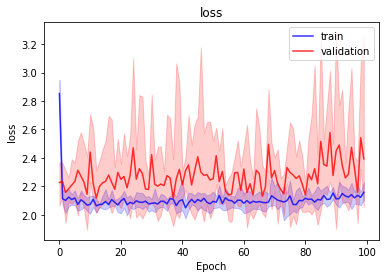

<b>domain_BrayCurtis</b>: 0.1947 (min: 0.1911, max: 0.2006)

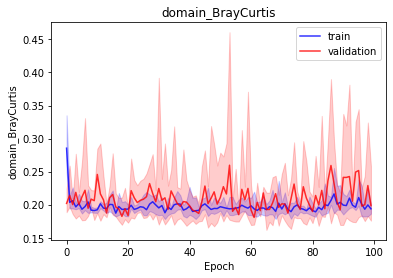

<b>domain_pearson_corr</b>: 0.9385 (min: 0.9354, max: 0.9407)

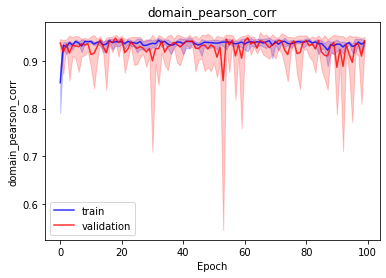

<b>domain_jensen_shannon_divergence</b>: 0.2093 (min: 0.2012, max: 0.2239)

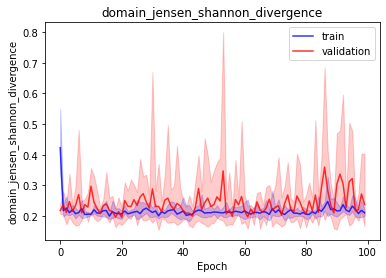

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 2.0633802319543215 | 2.0171336363217858 | 2.114575646968843 |
| domain_BrayCurtis | 0.19471709430217743 | 0.1910715103149414 | 0.20063985884189606 |
| domain_pearson_corr | 0.9384528994560242 | 0.9353829622268677 | 0.9407467246055603 |
| domain_jensen_shannon_divergence | 0.20927658677101135 | 0.20118901133537292 | 0.22387148439884186 |


[('best_lost_epoch', 12),
 ('val_loss', [2.1176311901637486, 2.012844775404249, 2.3110593387058804]),
 ('val_domain_BrayCurtis', [0.2072092, 0.18544638, 0.24312821]),
 ('val_domain_pearson_corr', [0.9293591, 0.90005016, 0.9459409]),
 ('val_domain_jensen_shannon_divergence', [0.22473805, 0.1832265, 0.28392568])]

In [17]:
print_results(results)

In [18]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_MLP_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.20102110505104065 | 0.17255625128746033 | 0.2664097845554352 |
| pearson_corr | 0.9403883218765259 | 0.9308677911758423 | 0.9501768946647644 |
| jensen_shannon_divergence | 0.2137686312198639 | 0.1583438664674759 | 0.38825616240501404 |


# 3. Auto-encoder combined latent <a name="AE_combined"></a>

In [19]:
from train_2 import *

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 5 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>97</b></p>

<b>loss</b>: 0.2203 (min: 0.2182, max: 0.2250)

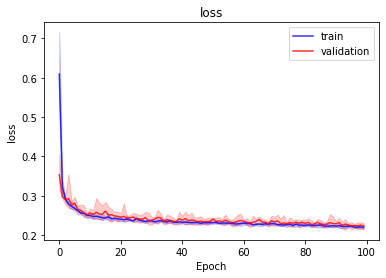

<b>bioma_loss</b>: 0.0414 (min: 0.0395, max: 0.0441)

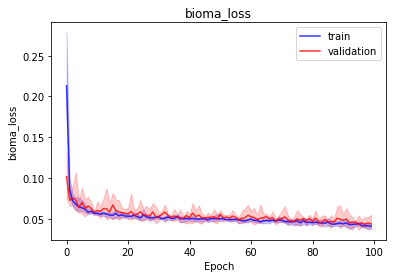

<b>domain_loss</b>: 0.1666 (min: 0.1647, max: 0.1687)

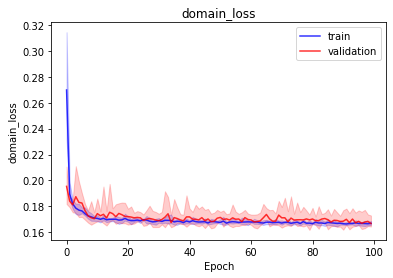

<b>latent_loss</b>: 0.0122 (min: 0.0112, max: 0.0137)

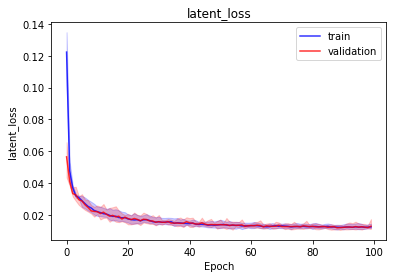

<b>bioma_mse</b>: 0.0002 (min: 0.0002, max: 0.0002)

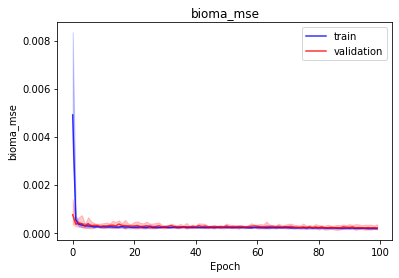

<b>bioma_mae</b>: 0.0049 (min: 0.0047, max: 0.0052)

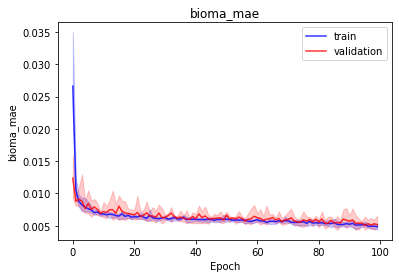

<b>bioma_mape</b>: 39931.9766 (min: 37144.9375, max: 42575.8633)

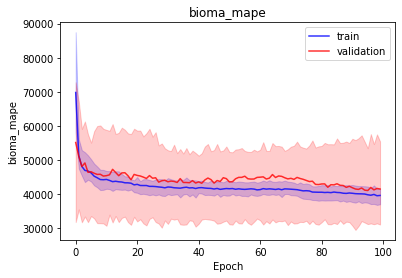

<b>bioma_BrayCurtis</b>: 0.0415 (min: 0.0395, max: 0.0442)

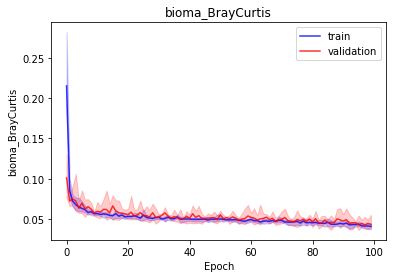

<b>bioma_pearson_corr</b>: 0.9936 (min: 0.9933, max: 0.9941)

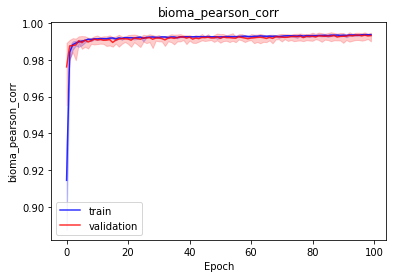

<b>bioma_jensen_shannon_divergence</b>: 0.0523 (min: 0.0489, max: 0.0549)

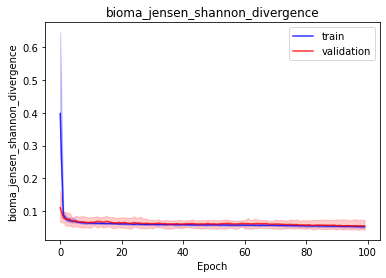

<b>domain_mse</b>: 0.0029 (min: 0.0028, max: 0.0030)

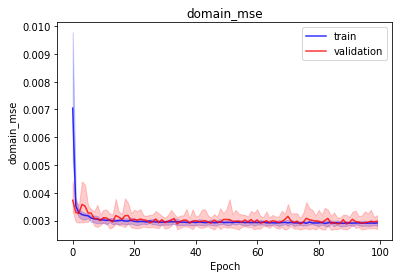

<b>domain_mae</b>: 0.0206 (min: 0.0203, max: 0.0208)

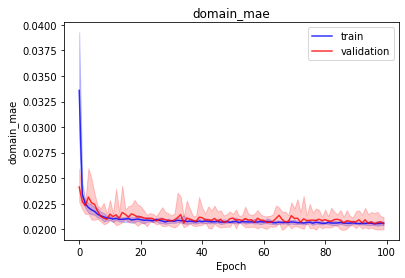

<b>domain_mape</b>: 59477.8320 (min: 55085.1523, max: 64578.8789)

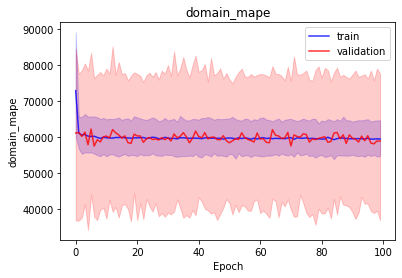

<b>domain_BrayCurtis</b>: 0.1665 (min: 0.1650, max: 0.1687)

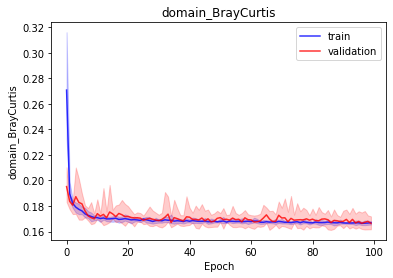

<b>domain_pearson_corr</b>: 0.9554 (min: 0.9545, max: 0.9567)

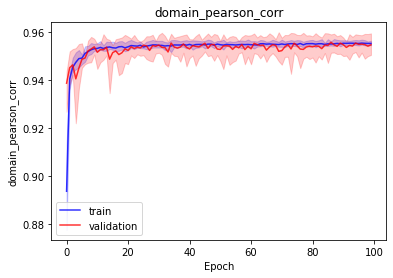

<b>domain_jensen_shannon_divergence</b>: 0.1725 (min: 0.1659, max: 0.1800)

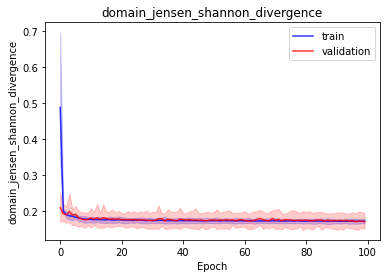

<b>latent_mae</b>: 0.0122 (min: 0.0112, max: 0.0137)

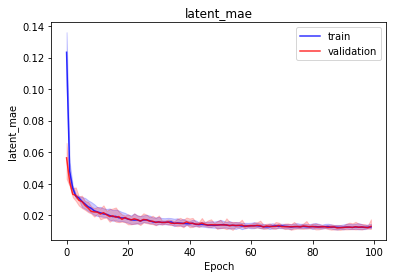

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.22029678705153993 | 0.21817272714887145 | 0.22499369265348973 |
| bioma_loss | 0.04140876978635788 | 0.03953252732753754 | 0.04405815526843071 |
| domain_loss | 0.16664855182170868 | 0.16473346948623657 | 0.1687387079000473 |
| latent_loss | 0.012247125618159771 | 0.01118442788720131 | 0.013652618043124676 |
| bioma_mse | 0.00017611162911634892 | 0.0001604770077392459 | 0.00019929803966078907 |
| bioma_mae | 0.004924292676150799 | 0.004666829016059637 | 0.005247637629508972 |
| bioma_mape | 39931.9765625 | 37144.9375 | 42575.86328125 |
| bioma_BrayCurtis | 0.04151109606027603 | 0.03953948989510536 | 0.04418591782450676 |
| bioma_pearson_corr | 0.9935804605484009 | 0.9932775497436523 | 0.9940976500511169 |
| bioma_jensen_shannon_divergence | 0.05233978480100632 | 0.048945896327495575 | 0.05493950843811035 |
| domain_mse | 0.0029128529131412506 | 0.0028124889358878136 | 0.003013673471286893 |
| domain_mae | 0.02055313065648079 | 0.020347580313682556 | 0.02080598846077919 |
| domain_mape | 59477.83203125 | 55085.15234375 | 64578.87890625 |
| domain_BrayCurtis | 0.16654080152511597 | 0.16498512029647827 | 0.16865174472332 |
| domain_pearson_corr | 0.9553952217102051 | 0.9545379281044006 | 0.9567221403121948 |
| domain_jensen_shannon_divergence | 0.1725427806377411 | 0.16587507724761963 | 0.1799812763929367 |
| latent_mae | 0.012244890443980694 | 0.011157575994729996 | 0.013702978380024433 |


*************

In [20]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=5, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        #layers=[128],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=data_domain_train,
                        show_results=True, 
                        device='/CPU:0')

In [21]:
predictions = test_model_cv_predictions(models, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_aggregated_phylum_testSet_AE_combinedLatent_5CV_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.16274523735046387 | 0.16274523735046387 | 0.16274523735046387 |
| pearson_corr | 0.9559779167175293 | 0.9559779167175293 | 0.9559779167175293 |
| jensen_shannon_divergence | 0.14265747368335724 | 0.14265747368335724 | 0.14265747368335724 |


# 4. Auto-encoder OTU latent <a name="AE_latentOTU"></a>

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 128 -> 10 -> 128 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.0254 (min: 0.0254, max: 0.0254)

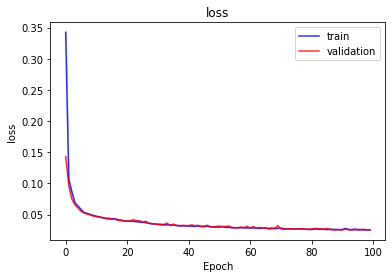

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

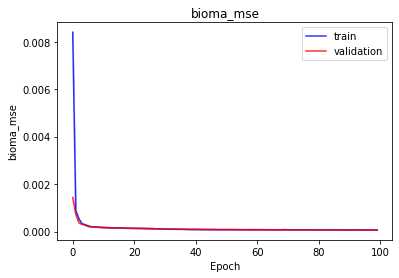

<b>bioma_mae</b>: 0.0029 (min: 0.0029, max: 0.0029)

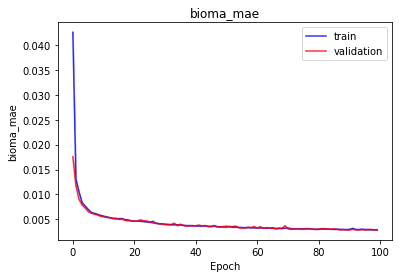

<b>bioma_mape</b>: 38426.5820 (min: 38426.5820, max: 38426.5820)

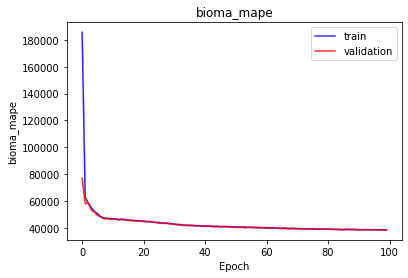

<b>bioma_BrayCurtis</b>: 0.0254 (min: 0.0254, max: 0.0254)

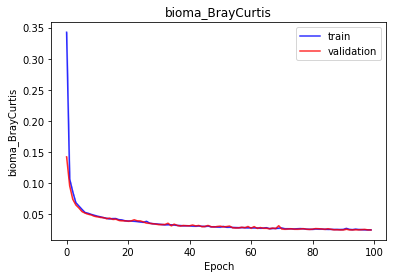

<b>bioma_pearson_corr</b>: 0.9945 (min: 0.9945, max: 0.9945)

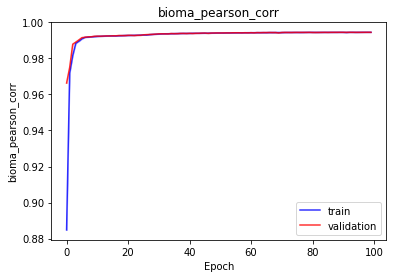

<b>bioma_jensen_shannon_divergence</b>: 0.0444 (min: 0.0444, max: 0.0444)

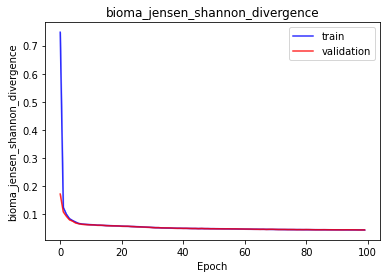

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.025374460269586813 | 0.025374460269586813 | 0.025374460269586813 |
| bioma_mse | 6.995700096013024e-05 | 6.995700096013024e-05 | 6.995700096013024e-05 |
| bioma_mae | 0.0029071976896375418 | 0.0029071976896375418 | 0.0029071976896375418 |
| bioma_mape | 38426.58203125 | 38426.58203125 | 38426.58203125 |
| bioma_BrayCurtis | 0.025374457240104675 | 0.025374457240104675 | 0.025374457240104675 |
| bioma_pearson_corr | 0.9945206046104431 | 0.9945206046104431 | 0.9945206046104431 |
| bioma_jensen_shannon_divergence | 0.04440568387508392 | 0.04440568387508392 | 0.04440568387508392 |


*************

In [22]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        #layers=[512,256],
                        layers=[128],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in domain->latent model

In [23]:
model, encoder, _ ,decoder = models[0]

In [24]:
df_domain_train.shape

(4251, 3)

### To predict latent space for samples in domain->latent model

In [25]:
latent_train = encoder.predict(data_microbioma_train)
latent_test = encoder.predict(data_microbioma_test)

### To build model to predict latent space 

In [26]:
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [27]:
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                            latent_train,
                            latent_train,
                            data_domain_train,
                            data_domain_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

In [28]:
print_results_noEnsemble(result_latent)

<p>Best iteration: <b>92</b></p>

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.019977879152216774 | 0.019105845379420335 | 0.05091320588865776 |
| domain_mean_squared_error | 0.019977878779172897 | 0.01910584047436714 | 0.05091319605708122 |


In [29]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_latent, latent_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_domain-latent_AE_OTUlatent_3var.txt)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.018826864659786224 | 6.001279473366594e-10 | 0.8279155492782593 |


### Domain -> latent -> microbiome. Test set

In [30]:
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.15911369025707245 | 0.15911369025707245 | 0.15911369025707245 |
| pearson_corr | 0.9575635194778442 | 0.9575635194778442 | 0.9575635194778442 |
| jensen_shannon_divergence | 0.1374267041683197 | 0.1374267041683197 | 0.1374267041683197 |


## Predictions

##### Run prediction test set from domain (i.e. environmental features)

In [31]:
pred_latent = model_latent.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)

##### Original relative abundances test set, to compare with predictions

In [32]:
actual = transform_to_rel_abundance(data_microbioma_test)

#### Pearson correlation

In [33]:
def compute_pearson_Nsamples(actual,pred_domain):
    tot = 0.0
    count = 0
    for i, (act,pred) in enumerate(zip(actual,pred_domain)):
        r, _ = scipy.stats.pearsonr(act,pred)
        if not np.isnan(r):
            count += 1
            tot += r
    r_final = tot/count
    return r_final

In [34]:
compute_pearson_Nsamples(actual,pred_domain)

0.9601375706574642

==> This is not exactly the same as the values computed above, with some percentage of difference (0.9601 vs 0.9576)

#### Bray-Curtis

In [35]:
def compute_braycurtis_Nsamples(actual,pred_domain):
    tot_bc = 0.0
    for i, (act,pred) in enumerate(zip(actual,pred_domain)):
        bc_dm = beta_diversity("braycurtis", [act,pred]) # Source: http://scikit-bio.org/docs/0.4.2/diversity.html
        bc = bc_dm[0,1]
        tot_bc += bc
    bc_final = tot_bc/(pred_domain.shape[0])
    return bc_final

In [36]:
compute_braycurtis_Nsamples(actual,pred_domain)

0.15841075267489543

==> This is not exactly the same as the values computed above, with some percentage of difference (0.1584 vs 0.1591)